<center>МИНИСТЕРСТВО НАУКИ И ВЫСШЕГО ОБРАЗОВАНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ </center>
<center>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ </center>
<center>«НОВОСИБИРСКИЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ»</center>
<center>Кафедра Вычислительной техники </center>
<br>
<center> <b> <font size="5">  ОТЧЁТ </font>  </b>  </center>   
<center><font size="3">по лабораторной работе №2</font></center>
<center><font size="3">по дисциплине: «Системы искусственного интеллекта и машинное обучение» </font></center>
<br>

Выполнили:
- _ _ _ Дмитриченко Д.А. _ _ _
- _ _ _ Опрышко М.А. _ _ _

Проверил: _ _ _ Осипенко И.В. _ _ _

<center>  Новосибирск, 2025  </center>

# Лабораторная работа #2

## Цель работы

Исследование влияния операции приведения данных к новым шкалам (стандартизации) на обучение моделей МО при решении задачи регрессии, с использованием библиотеки scikit-learn.
Знакомство с приемом перекрестной проверки данных (cross-validation).


- - -

In [1]:
# Проверка версии и пути к выбранному интерпретатору
import sys
import json
print(f"Версия Python - {sys.version}")
print(f"Путь к интерпретатору Python - {sys.executable}")

Версия Python - 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Путь к интерпретатору Python - C:\Users\ASUS\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


In [ ]:

# Python 3.8
import pandas as pd
import numpy  as np

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

: 

In [4]:
# Проверка версий библиотек
for lib in [pd, np, sklearn]:
    print(f"{lib.__name__:<12} {lib.__version__}")

pandas       2.3.2
numpy        2.2.6
sklearn      1.7.2


# Объявление функций

Для повышения повторяемости кода и повышения уровня читаемости объявим несколько функций с уже знакомыми операциями

In [5]:
def PLOT34(y_test, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    plt.figure(figsize=(12,6))

    # == Диаграмма рассеяния вычисленных значений ==
    # создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс текущего полотна в сетке
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1, color = "#17becf")
    plt.plot(  [ np.min(y_test), np.max(y_test) ], # x1,x2
               [ np.min(y_test), np.max(y_test) ], # y1,y2
               '--',
               alpha=0.7, lw=3, color = "black")
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')
    plt.grid(True)  # Сетка. Доп параметры color='black', linewidth=0.7

    # == Диаграмма рассеяния ошибок ==
    # создать второе полотно 121: 1-строк, 2-столбцов, 2-индекс текущего полотна в сетке
    plt.subplot(122)
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1, color = "#17becf")
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')
    plt.grid(True)  # Сетка. Доп параметры color='black', linewidth=0.7
#--------------------------------------------------------------------------

In [6]:
def PLOTHIST(y_test, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    plt.figure(figsize=(6,4))

    # Гистограмма и Плотность распределения - sns.distplot
    # data = y_true - y_pred
    sns.histplot( data = y_test - y_pred,
                color="red",
                kde=True, # оценка плотности в виде кривой
                stat="density",# density: общая площадь равна 1
                )

    # Осевая линия
    # plt.plot(
    #     [0, 0],
    #     [0, 10 * pow(10,-7)], '--', lw=2, c='r')

    plt.ylabel(u'Плотность')
    plt.xlabel(u'Значение ошибки')
    plt.title(u'Плотность распределения и гистограмма ошибок');
    plt.show()
#--------------------------------------------------------------------------

In [7]:
def GET_METRICS_SINGLE(y_test, y_pred) -> None:
    '''
    Вычисление и вывод метрик: MAE, RMSE, R2. Используются функции из библиотеки sklearn
    На основе сравнения проверочных и вычисленных.
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    mae  = metrics.mean_absolute_error        (y_test, y_pred)
    mse  = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = metrics.r2_score                   (y_test, y_pred)

    print ("MAE : {:>9,.3f} (средняя абсолютная ошибка)".format              ( mae ))
    print ("MSE : {:>9,.6f} (среднеквадратичная ошибка)".format( mse ))
    print ("RMSE: {:>9,.6f} (кв. корень из среднеквадратичной ошибки)".format( rmse ))
    print ("R2  : {:>9,.3f} (коэфф. детерминации)".format                    ( r2 ))
#--------------------------------------------------------------------------

- - -

# Загрузка подготовленных данных

In [8]:
df = pd.read_csv(
    '../Data/Moscow_Housing_Price_FILTERED.csv', # путь к файлу, (используй автодотолнение)
    sep=',', # разделитель данных в файле
    header=0, # номер строки с заголовками, нумерация с нуля
    # header='None', # если заголовки отсутствуют
    )
print("Размер таблицы", df.shape)
df[:2]

Размер таблицы (19366, 18)


,Price,Metro station,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Apartment_type_Digit,Region_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Renovation_N_European-style renovation,Renovation_N_Without renovation,Living_share,Kitchen_share,Is_first_floor
0,9000000.0,Павшино,2.0,1.0,49.2,20.0,10.0,6.0,15,0,0,0,0,1,0,0.406504,0.203252,0
1,11090000.0,Мякинино,14.0,1.0,44.7,16.2,13.1,10.0,25,0,0,1,0,0,0,0.362416,0.293065,0


Для начала определим точный список признаков с целевой и независимыми признаками, а после оставим в таблице только перечисленные столбцы.

In [9]:
features = [
    'Renovation_N_European-style renovation',
    'Floor',
    'Is_first_floor',
    'Number of floors',
    'Living_share',
    'Minutes to metro',
    'Renovation_N_Without renovation',
    'Region_Digit',
    'Kitchen_share',
    'Apartment_type_Digit',
    'Renovation_N_Cosmetic',
    'Renovation_N_Designer',
    'Number of rooms',
    'Kitchen area',
    'Metro station',
    'Living area',
    'Area'
]
target   = ['Price']

Для выполнения следующих шагов разделим исходую таблицу на две отдельных
  - dfX содержащую только объясняющие признаки
  - dfY содержащую только целевой объясняемый признак

In [10]:
dfX = df[features]
print("Размер таблицы", dfX.shape)
dfX[:2]

Размер таблицы (19366, 17)


,Renovation_N_European-style renovation,Floor,Is_first_floor,Number of floors,Living_share,Minutes to metro,Renovation_N_Without renovation,Region_Digit,Kitchen_share,Apartment_type_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Number of rooms,Kitchen area,Metro station,Living area,Area
0,1,6.0,0,15,0.406504,2.0,0,0,0.203252,0,0,0,1.0,10.0,Павшино,20.0,49.2
1,0,10.0,0,25,0.362416,14.0,0,0,0.293065,0,1,0,1.0,13.1,Мякинино,16.2,44.7


In [11]:
dfY = df[target]
print("Размер таблицы", dfY.shape)
dfY[:2]

Размер таблицы (19366, 1)


,Price
0,9000000.0
1,11090000.0


# Приведение к новой шкале значений

Важнейшими числовыми характеристиками случайной величины являются:

- Минимальное (min) и максимальное (max) значения
    - `df["featureName"].min()`
    - `df["featureName"].max()`


- Математическое ожидание, имеющее смысл среднего значения  (mean)  $ {\\mu = μ
} $ (мю) - центр распределения случайной величины
    - `df["featureName"].mean()`
      
- Среднеквадратическое/стандартное отклонение (Standard_deviation) $ {\\sigma = σ} $ (сигма) - показатель рассеивания относительно её мат. ожидания
    - `df["featureName"].std()`
      
- Дисперсия (Variance) $ {\\var = sigma^2 = σ^2} $ (сигма в квадрате) - мера разброса относительно её мат. ожидания
    - `df["featureName"].var()`
    - `df["featureName"].std()**2`

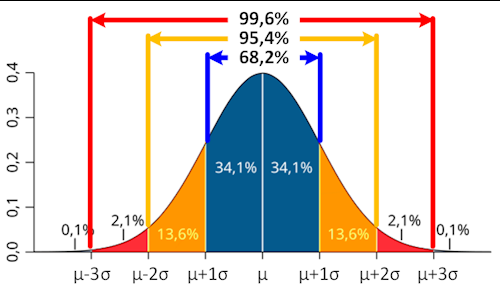

<p style="text-align: right;"> Рисунок. Гистограмма </p>

Некоторые методы машинного обучения чувствительны к тому, какой порядок величин имеют значения признаков данных.

При подготовки данных чаще всего выполняются следующие процедуры преобразования к новым диапазонам значений (шкалам) :

- __Нормализация__  -  приведения значений к диапазону от 0.0 до 1.0 Пример:
      
      |--------------|+++++++++|----|
      |--------------|++++++++++++++|
      0             1900     1970  2000
      
      Обрабатываемое: 1970
      Макс. значение: 1900
      Мин. значение:  2000
      
      Процедура нормализации:
      x_norm = ( x - X.min() ) / ( X.max() -  X.min() )
      x_norm = ( 1970 - 1900 ) / (2000 - 1900)
      x_norm = 70 / 100
      x_norm = 0.70
      
      Восстановление:
      x = ( x_norm * ( X.max() -  X.min() ) +  X.min()
      x = ( 0.70 * (2000 - 1900) + 1900
      x = ( 0.70 * 100) + 1900
      x = 70 + 1900
      x = 1970

<div>

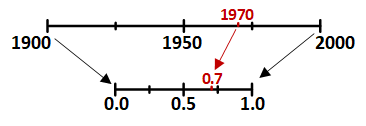
<p style="text-align: right;"> Рисунок. Вид диапазона значений до и после нормализации </p>
</div>


- __Стандартизация__ - предобработки данных, после которой каждый признак имеет среднее (mean) = 0 и стандартное отклонение (standart deviation) = 1. Стандартизовать - вычесть среднее и поделить на стандартное отклонение. Критично для линейных моделей.

      Процедура cтандартизаци:
      X_stantartised = (X - X.mean()) / X.std()

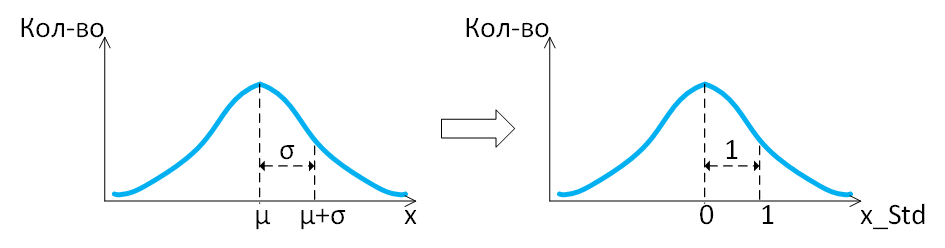
<p style="text-align: right;"> Рисунок. Вид гистограмм до и после стандартизации </p>

"Одно из наиболее важных допущений при работе с линейными моделями, параметры которых оцениваются методом наименьших квадратов, состоит в том, что остатки модели независимы (т.е. не коррелируют) и имеют нормальное распределение со средним значением 0 и некоторым фиксированным стандартным отклонением"

Рассмотрим выполение стандартизации на примере обработки новой таблицы, которая содержит условного значения годов.

- - -

Для дальнейшей работы рассмотрим способы выполнения операции стандартизации.

Правильный порядок
1. Очистка данных (выбросы, пропуски и т. д.).

2. Разделение на train/test (чтобы избежать утечки).

3. Кодирование категориальных признаков (например, TargetEncoder обучается на train, потом применяется к test).

4. Стандартизация числовых признаков (например, StandardScaler обучается на train, потом применяется к test).

# Формирование тренировочной и проверочной выборок

In [12]:
rand_seed = 8 # начальное состояние генератора случ. чисел

In [13]:
valid_size = 0.3 # доля тестовой части в выборке

##  НЕ Стандартизованные

In [14]:
x_train, x_test, y_train, y_test =  train_test_split(
    df[features],    # исходные данные X
    df[target],      # исходные данные y

    test_size = valid_size, # доля тестовой части в выборке
    random_state=rand_seed, # начальное состояние генератора случ. чисел
    shuffle=True            # перемешивание
)
y_train = y_train['Price']
y_test = y_test['Price']

x_train[:2]

,Renovation_N_European-style renovation,Floor,Is_first_floor,Number of floors,Living_share,Minutes to metro,Renovation_N_Without renovation,Region_Digit,Kitchen_share,Apartment_type_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Number of rooms,Kitchen area,Metro station,Living area,Area
15802,0,10.0,0,17,0.351913,8.0,0,0,0.278696,1,1,0,1.0,11.8,Котельники,14.9,42.34
10752,0,22.0,0,11,0.642729,19.0,0,1,0.319569,1,1,0,0.0,8.9,Депо,17.9,27.85


In [15]:
y_train[:2]

15802    5981244.0
10752    5514300.0
Name: Price, dtype: float64

In [16]:
print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test),
    len(x_train)+len(x_test), len(y_train)+len(x_test),
))

Кол-во элементов: 
  x_train: 13556, y_train 13556 
  x_test:  5810, y_test  5810 
  total x: 19366, total y 19366 


## TargetEncoder

In [34]:
# список категориальных признаков
cat_features = ['Metro station']

# инициализация двоичного кодировщика
# Обучение энкодера на train
encoder = ce.TargetEncoder(cols=['Metro station'])
x_train_enc = encoder.fit_transform(x_train, y_train)

# преобразуем данные для тестирования
x_test_enc = encoder.transform(x_test)

x_train_enc.head()

,Renovation_N_European-style renovation,Floor,Is_first_floor,Number of floors,Living_share,Minutes to metro,Renovation_N_Without renovation,Region_Digit,Kitchen_share,Apartment_type_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Number of rooms,Kitchen area,Metro station,Living area,Area
15802,0,10.0,0,17,0.351913,8.0,0,0,0.278696,1,1,0,1.0,11.8,6.745041e+06,14.9,42.34
10752,0,22.0,0,11,0.642729,19.0,0,1,0.319569,1,1,0,0.0,8.9,9.398309e+06,17.9,27.85
893,0,9.0,0,32,0.709677,1.0,1,1,0.215989,0,0,0,0.0,15.4,1.607055e+07,50.6,71.30
12641,0,16.0,0,11,0.537202,19.0,0,1,0.156250,1,1,0,2.0,10.5,9.398309e+06,36.1,67.20
5587,0,5.0,0,17,0.596078,11.0,0,1,0.166667,0,1,0,2.0,8.5,9.783399e+06,30.4,51.00


## Стандартизация

В библиотеке scikit-learn, для выполнения процедуры стандартизации, присутствует более удобный класс __sklearn.preprocessing.StandardScaler__, который содержит методы:

- __StandardScaler.fit(  X  )__ - вычисление значений __среднего__ и __дисперсии__

- __StandardScaler.transform( X )__ - прямого преобразования из истинного значения к приведенному

- __StandardScaler.inverse_transform( X )__ - обратного преобразования из приведенного значения в истинное

Стандартизатор (StandardScaler) нужно обучать только на train (fit), а потом применять к test (transform).

Нельзя обучать scaler на всём датасете, иначе произойдёт утечка информации.

In [18]:
from sklearn.preprocessing import StandardScaler
scalerStdX = StandardScaler()
scalerStdY = StandardScaler()

In [19]:
#  вычисление значений среднего и дисперсии отдельно для каждого признака
scalerStdX.fit (x_train_enc)
scalerStdY.fit (y_train.to_frame())

,copy,True
,with_mean,True
,with_std,True


Осмотрим значения среднего и ср.кв.откл. для независимых переменных.

In [20]:
print (" {:>3} {:<40} {:>16} {:>16}".format(
 "№", "Признак", "Средрее", "Ср.кв.откл."
))

for icol in range (0, len(dfX.columns)):
    print (
        " {:>3} {:<40} {:>16.3f} {:>16.3f}".format(
                icol,
                dfX.columns[icol],
                scalerStdX.mean_[icol],
                np.sqrt ( scalerStdX.var_[icol]), # кв. корень (из дисперсии)
                ))

   № Признак                                           Средрее      Ср.кв.откл.
   0 Renovation_N_European-style renovation              0.163            0.369
   1 Floor                                               8.851            6.391
   2 Is_first_floor                                      0.068            0.252
   3 Number of floors                                   15.978            7.245
   4 Living_share                                        0.555            0.101
   5 Minutes to metro                                   12.105            5.788
   6 Renovation_N_Without renovation                     0.118            0.322
   7 Region_Digit                                        0.676            0.468
   8 Kitchen_share                                       0.224            0.100
   9 Apartment_type_Digit                                0.477            0.499
  10 Renovation_N_Cosmetic                               0.638            0.481
  11 Renovation_N_Designer              

При прямом преобразовании значений (функция transform()) данные возвращаются без информации о принадлежности к строкам и столбцам.

In [21]:
# Пример для осмотра предварительного результата
scalerStdX.transform(x_train_enc)

array([[-0.44134148,  0.17977182, -0.27092893, ..., -0.87795569,
        -0.89398049, -0.44075073],
       [-0.44134148,  2.05750655, -0.27092893, ..., -0.56403061,
        -0.72196583, -0.95038087],
       [-0.44134148,  0.02329392, -0.27092893, ...,  0.22540479,
         1.15299392,  0.57780613],
       ...,
       [-0.44134148,  1.74455076, -0.27092893, ...,  0.94394329,
         1.88692312,  1.43879618],
       [-0.44134148,  0.6492055 , -0.27092893, ..., -0.56403061,
        -0.37793652, -0.41753776],
       [ 2.2658192 ,  1.11863918, -0.27092893, ..., -0.33495218,
         0.86630283,  0.64463134]], shape=(13556, 17))

Для удобства восприятия сформируем новую таблицу (DataFrame) с указанием названий признаков и идентификаторов строк, соответствующих таблице-оригиналу. Сравните значения с таблицей в п. 5.1.

In [22]:
# создать новую таблицу (DataFrame)
# со стандартизированными значениями

x_train_enc_std = pd.DataFrame (
  data    = scalerStdX.transform(x_train_enc), # значения ячеек    <<--
  columns = x_train_enc.columns,           # названия столбцов
  index   = x_train_enc.index              # идентификаторы строк
)
print("Размер таблицы", x_train_enc_std.shape)
x_train_enc_std[:2]

Размер таблицы (13556, 17)


,Renovation_N_European-style renovation,Floor,Is_first_floor,Number of floors,Living_share,Minutes to metro,Renovation_N_Without renovation,Region_Digit,Kitchen_share,Apartment_type_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Number of rooms,Kitchen area,Metro station,Living area,Area
15802,-0.441341,0.179772,-0.270929,0.141118,-2.008237,-0.709310,-0.365171,-1.443264,0.551417,1.047761,0.752865,-0.297024,-0.615648,0.226937,-0.877956,-0.893980,-0.440751
10752,-0.441341,2.057507,-0.270929,-0.687019,0.869228,1.191208,-0.365171,0.692874,0.961918,1.047761,0.752865,-0.297024,-1.387829,-0.418936,-0.564031,-0.721966,-0.950381


In [23]:
# создать новую таблицу (DataFrame)
# со стандартизированными значениями

y_train_std = pd.DataFrame (
  data    = scalerStdY.transform(y_train.to_frame()), # значения ячеек    <<--
  columns = y_train.to_frame().columns,           # названия столбцов
  index   = y_train.to_frame().index              # идентификаторы строк
)
print("Размер таблицы", y_train_std.shape)
y_train_std[:2]

Размер таблицы (13556, 1)


,Price
15802,-0.615062
10752,-0.643771


In [24]:
# создать новую таблицу (DataFrame)
# со стандартизированными значениями

x_test_enc_std = pd.DataFrame (
    data    = scalerStdX.transform(x_test_enc), # значения ячеек    <<--
    columns = x_test_enc.columns,           # названия столбцов
    index   = x_test_enc.index              # идентификаторы строк
)
print("Размер таблицы", x_test_enc_std.shape)
x_test_enc_std[:2]

Размер таблицы (5810, 17)


,Renovation_N_European-style renovation,Floor,Is_first_floor,Number of floors,Living_share,Minutes to metro,Renovation_N_Without renovation,Region_Digit,Kitchen_share,Apartment_type_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Number of rooms,Kitchen area,Metro station,Living area,Area
8091,-0.441341,-0.759096,-0.270929,-0.963065,2.255569,0.154561,-0.365171,0.692874,-1.251375,-0.954416,0.752865,-0.297024,1.700893,-0.753008,0.178992,1.600232,0.693871
12106,-0.441341,0.805683,-0.270929,0.555187,-2.215057,-0.018213,-0.365171,-1.443264,1.951686,1.047761,0.752865,-0.297024,-0.615648,0.805996,-0.944005,-1.094664,-0.718603


In [25]:
# создать новую таблицу (DataFrame)
# со стандартизированными значениями

y_test_std = pd.DataFrame (
    data    = scalerStdY.transform(y_test.to_frame()), # значения ячеек    <<--
    columns = y_test.to_frame().columns,           # названия столбцов
    index   = y_test.to_frame().index              # идентификаторы строк
)
print("Размер таблицы", y_test_std.shape)
y_test_std[:2]

Размер таблицы (5810, 1)


,Price
8091,0.234534
12106,-0.659621


## Информация по целевой переменной
Получите величину среднего значения и дисперсии для целевой переменной

In [26]:
print (" {:>3} {:<25} {:>16} {:>16}".format(
 "№", "Признак", "Средрее", "Ср.кв.откл."
))

for icol in range (0, len(y_train.to_frame().columns)):
    print (
        " {:>3} {:<25} {:>16.3f} {:>16.3f}".format(
                icol,
                dfY.columns[icol],
                scalerStdY.mean_[icol],
                np.sqrt ( scalerStdY.var_[icol]), # кв. корень (из дисперсии)
                ))

   № Признак                            Средрее      Ср.кв.откл.
   0 Price                         15985289.774     16265096.720


In [37]:
x_train_enc_std.mean()

Renovation_N_European-style renovation   -1.079757e-16
Floor                                     1.037824e-16
Is_first_floor                            7.285736e-17
Number of floors                         -9.539597e-17
Living_share                              3.957360e-17
Minutes to metro                          5.346368e-17
Renovation_N_Without renovation           2.096615e-17
Region_Digit                              8.648536e-17
Kitchen_share                             2.332484e-16
Apartment_type_Digit                      1.257969e-17
Renovation_N_Cosmetic                    -3.144922e-17
Renovation_N_Designer                    -1.886953e-17
Number of rooms                          -8.176797e-17
Kitchen area                              1.561978e-16
Metro station                            -7.547813e-17
Living area                               1.394249e-16
Area                                     -2.479247e-16
dtype: float64

In [38]:
x_train_enc_std.std()

Renovation_N_European-style renovation    1.000037
Floor                                     1.000037
Is_first_floor                            1.000037
Number of floors                          1.000037
Living_share                              1.000037
Minutes to metro                          1.000037
Renovation_N_Without renovation           1.000037
Region_Digit                              1.000037
Kitchen_share                             1.000037
Apartment_type_Digit                      1.000037
Renovation_N_Cosmetic                     1.000037
Renovation_N_Designer                     1.000037
Number of rooms                           1.000037
Kitchen area                              1.000037
Metro station                             1.000037
Living area                               1.000037
Area                                      1.000037
dtype: float64

Постройте гистограммы распределения исходных и стандартизированных значений для целевого признака

(array([7534., 3423., 1004.,  508.,  348.,  247.,  170.,  137.,  116.,
          69.]),
 array([-0.89549359, -0.2894105 ,  0.31667259,  0.92275567,  1.52883876,
         2.13492184,  2.74100493,  3.34708801,  3.9531711 ,  4.55925418,
         5.16533727]),
 <BarContainer object of 10 artists>)

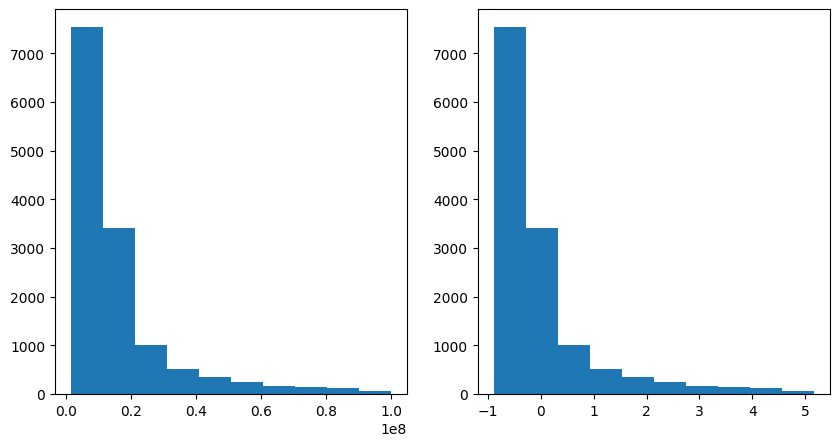

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.hist(pd.DataFrame (
    scalerStdY.inverse_transform(
        y_train_std),
    columns = y_train.to_frame().columns,
))

plt.subplot(122)
plt.hist(y_train_std)

- - -

# Проверка влияния стандартизации

Для исследования влияния процесса стандартизации используем новый тип модели - __linear_model.SGDRegressor__. Особенности внутреннего устройства рассматривать пока не будем.

В библиотеке sklearn большинство методов обладают единым интерфейсом взаимодействия и содержат методы
```
- model.fit(x_train, y_train) - обучение модели, вычисление коэфф. для входных признаков

- y_pred = model.predict(x_test) - прогноз модели, вычисление откликов
```

## Модель SGDRegressor. НЕ стандартизованные (rand_seed = ...)

In [ ]:
# 1. Создать объект класса с моделью стохастического градиентного спуска
sgd_reg_nonStd = linear_model.SGDRegressor(
    loss='squared_error', # Метод наименьших квадратов (Ordinary least squares)
    max_iter=10000,
    tol=1e-3,
    random_state=8,
)

In [ ]:
# 2. Обучить модель (подобрать/подогнать параметры модели)  на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе
sgd_reg_nonStd.fit(x_train_enc,  y_train)

,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,10000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,8


In [ ]:
# 3. Получить вычисленные(predicted) зн. на НЕ СТАНДАРТИЗИРОВАНОМ проверочном наборе
y_pred = sgd_reg_nonStd.predict(x_test_enc)
y_pred

array([-4.01559847e+22, -1.58459455e+22, -3.80129610e+22, ...,
       -6.26128888e+22, -3.56425665e+22, -7.10608909e+22], shape=(5810,))

In [ ]:
y_test

8091     19800000.0
12106     5256492.0
8766      9500000.0
17507     4417357.0
8132     59500000.0
            ...    
8851      8000000.0
8185     34900000.0
1262      9500000.0
11343     4700000.0
9214     16700000.0
Name: Price, Length: 5810, dtype: float64

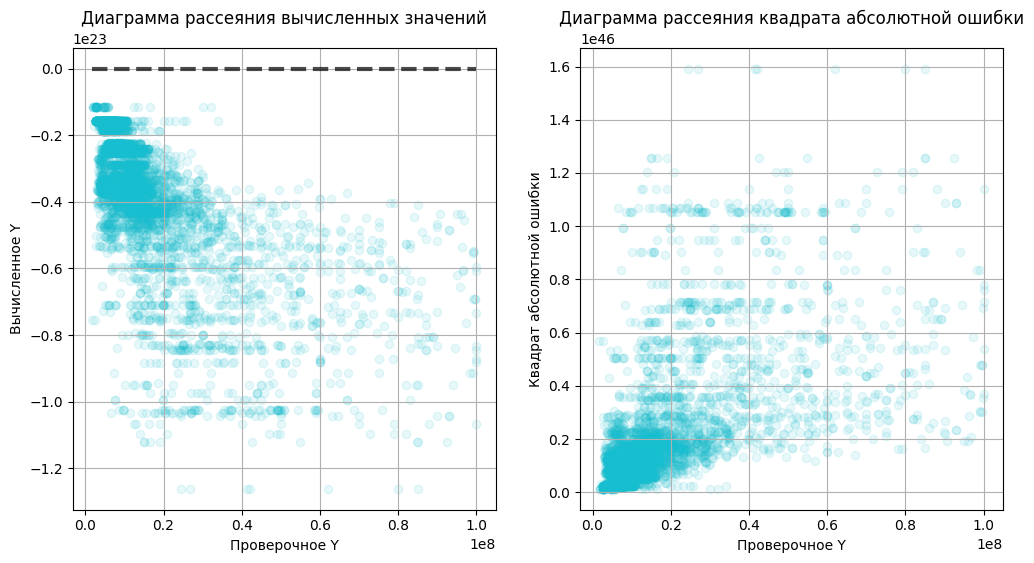

In [ ]:
# 4. Построить графики для оценки ошибки (вычисленные от проверочных)
PLOT34(
    y_test = y_test,
    y_pred = y_pred
)

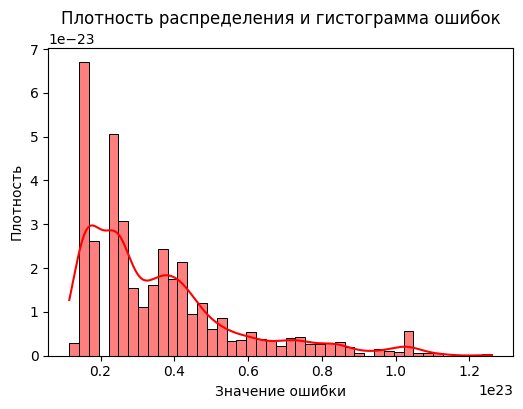

In [ ]:
PLOTHIST(
    y_test = y_test,
    y_pred = y_pred
)

In [ ]:
# 5. Получить численные оценки ошибки R2, RMSE, ...
GET_METRICS_SINGLE(
    y_test = y_test,
    y_pred = y_pred
)

MAE : 35,730,282,543,592,415,166,464.000 (средняя абсолютная ошибка)
MSE : 1,716,816,516,974,182,897,329,485,859,200,374,639,297,560,576.000000 (среднеквадратичная ошибка)
RMSE: 41,434,484,635,073,997,963,264.000000 (кв. корень из среднеквадратичной ошибки)
R2  : -6,784,952,630,415,570,211,261,609,148,416.000 (коэфф. детерминации)


In [ ]:
from sklearn.linear_model import LinearRegression

lr_nonStd = LinearRegression()
lr_nonStd.fit(x_train_enc, y_train)
y_pred_lr = lr_nonStd.predict(x_test_enc)

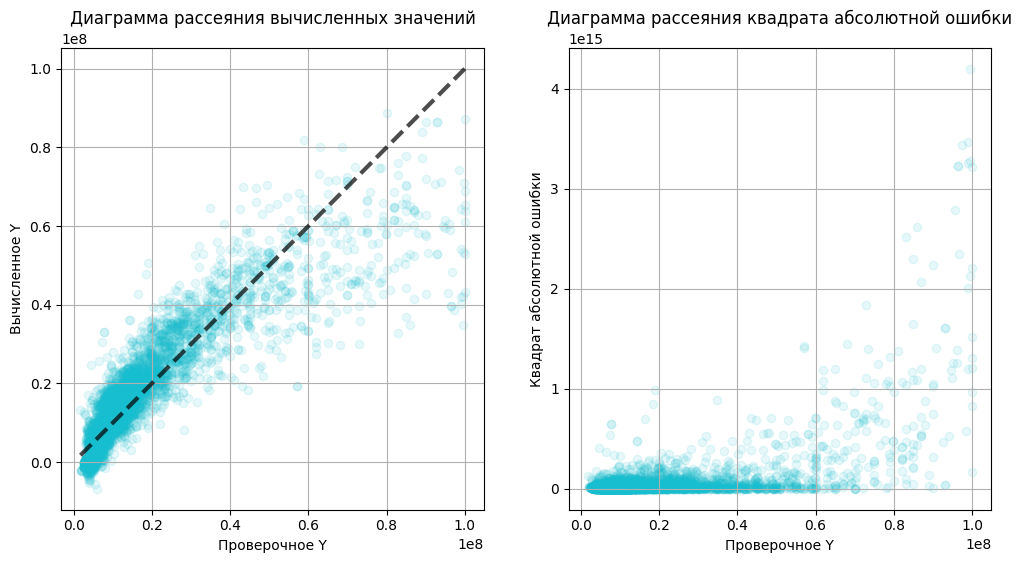

In [ ]:
# 4. Построить графики для оценки ошибки (вычисленные от проверочных)
PLOT34(
    y_test = y_test,
    y_pred = y_pred_lr
)

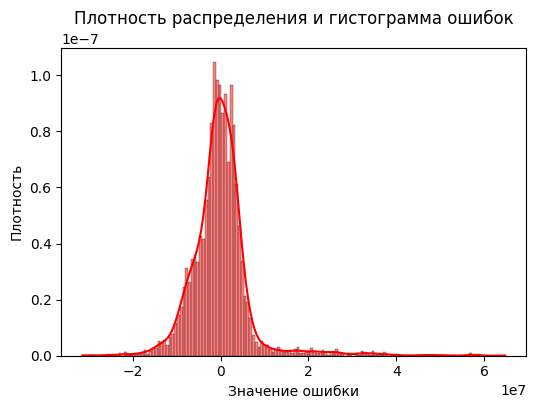

In [ ]:
PLOTHIST(
    y_test = y_test,
    y_pred = y_pred_lr
)

In [ ]:
# 5. Получить численные оценки ошибки R2, RMSE, ...
GET_METRICS_SINGLE(
    y_test = y_test,
    y_pred = y_pred_lr
)

MAE : 4,393,032.817 (средняя абсолютная ошибка)
MSE : 51,198,556,953,186.148438 (среднеквадратичная ошибка)
RMSE: 7,155,316.691327 (кв. корень из среднеквадратичной ошибки)
R2  :     0.798 (коэфф. детерминации)


## Модель SGDRegressor. Cтандартизованные. (rand_seed = ...)

In [41]:
# 1. Создать объект класса с моделью стохастического градиентного спуска
sgd_reg_std = linear_model.SGDRegressor(
    loss='squared_error', # Метод наименьших квадратов (Ordinary least squares)
    max_iter=10000,
    tol=1e-3,
    random_state=8,
)

In [42]:
# 2. Обучим модель (подберем/подогоним параметры модели)  на СТАНДАРТИЗИРОВАНОМ проверочном наборе
sgd_reg_std.fit(x_train_enc_std, y_train_std.values.ravel())

,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,10000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,8


In [43]:
# 3. Получить вычисленные(predicted) зн. на СТАНДАРТИЗИРОВАНОМ проверочном наборе
y_pred_std = sgd_reg_std.predict(x_test_enc_std)
y_pred_std

array([ 0.46143565, -0.71739112, -0.94657057, ...,  0.28769416,
       -0.54444857,  0.13148871], shape=(5810,))

In [44]:
y_test_std

,Price
8091,0.234534
12106,-0.659621
8766,-0.398724
17507,-0.711212
8132,2.675343
...,...
8851,-0.490946
8185,1.162902
1262,-0.398724
11343,-0.693835


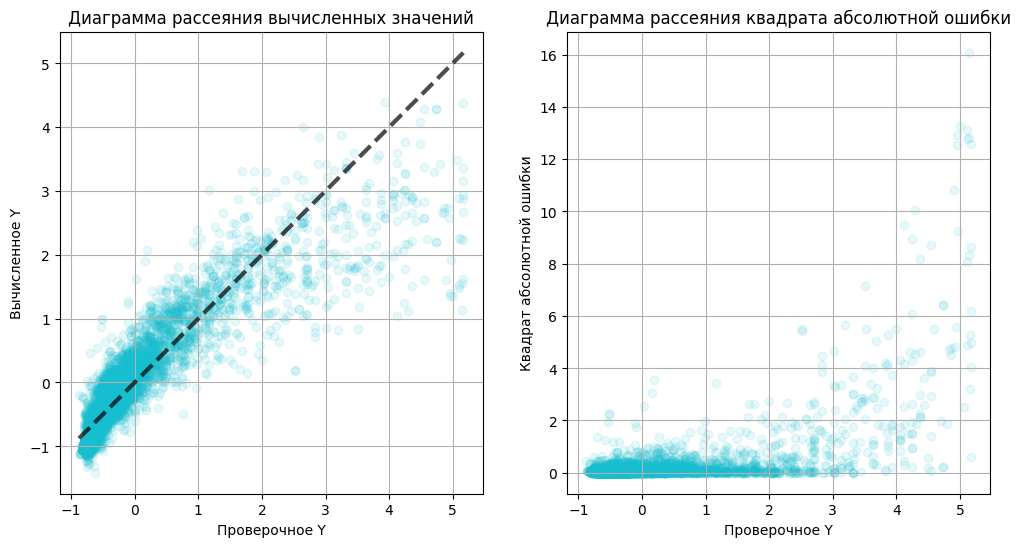

In [45]:
# 4. Построить графики для оценки ошибки (вычисленные от проверочных)
PLOT34(
    y_test = y_test_std['Price'],
    y_pred = y_pred_std
)

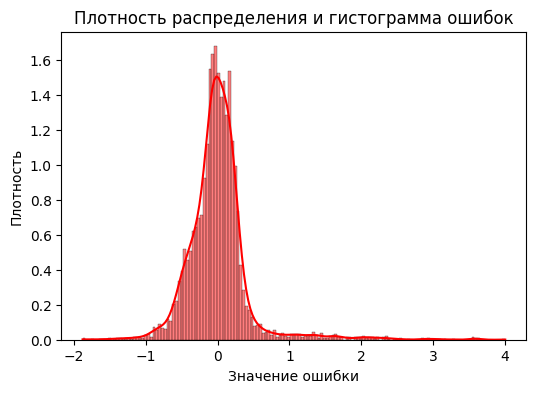

In [46]:
PLOTHIST(
    y_test = y_test_std['Price'],
    y_pred = y_pred_std
)

In [47]:
# 5. Получить численные оценки ошибки R2, RMSE, ...
GET_METRICS_SINGLE(
    y_test = y_test_std['Price'],
    y_pred = y_pred_std
)

MAE :     0.268 (средняя абсолютная ошибка)
MSE :  0.194554 (среднеквадратичная ошибка)
RMSE:  0.441083 (кв. корень из среднеквадратичной ошибки)
R2  :     0.797 (коэфф. детерминации)


In [49]:
x_train_enc_std

,Renovation_N_European-style renovation,Floor,Is_first_floor,Number of floors,Living_share,Minutes to metro,Renovation_N_Without renovation,Region_Digit,Kitchen_share,Apartment_type_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Number of rooms,Kitchen area,Metro station,Living area,Area
15802,-0.441341,0.179772,-0.270929,0.141118,-2.008237,-0.709310,-0.365171,-1.443264,0.551417,1.047761,0.752865,-0.297024,-0.615648,0.226937,-0.877956,-0.893980,-0.440751
10752,-0.441341,2.057507,-0.270929,-0.687019,0.869228,1.191208,-0.365171,0.692874,0.961918,1.047761,0.752865,-0.297024,-1.387829,-0.418936,-0.564031,-0.721966,-0.950381
893,-0.441341,0.023294,-0.270929,2.211461,1.531647,-1.918731,2.738441,0.692874,-0.078378,-0.954416,-1.328260,-0.297024,-1.387829,1.028711,0.225405,1.152994,0.577806
12641,-0.441341,1.118639,-0.270929,-0.687019,-0.174900,1.191208,-0.365171,0.692874,-0.678357,1.047761,0.752865,-0.297024,0.156532,-0.062592,-0.564031,0.321590,0.433604
5587,-0.441341,-0.602618,-0.270929,0.141118,0.407646,-0.190987,-0.365171,0.692874,-0.573739,-0.954416,0.752865,-0.297024,0.156532,-0.508022,-0.518468,-0.005238,-0.136168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,-0.441341,-0.289662,-0.270929,-0.272951,0.931786,-0.190987,-0.365171,0.692874,-1.009224,-0.954416,0.752865,-0.297024,0.928713,-0.374393,0.307582,0.998181,0.665734
10376,-0.441341,0.649205,-0.270929,0.003095,0.427954,1.363982,-0.365171,0.692874,-0.870973,1.047761,0.752865,-0.297024,0.156532,-1.421153,-0.518468,-0.647426,-0.800903
2181,-0.441341,1.744551,-0.270929,0.555187,1.059248,1.018433,2.738441,0.692874,-1.188561,-0.954416,-1.328260,-0.297024,0.928713,-0.151678,0.943943,1.886923,1.438796
18417,-0.441341,0.649205,-0.270929,-0.687019,0.009251,1.191208,-0.365171,0.692874,0.134747,1.047761,0.752865,-0.297024,-0.615648,-0.129407,-0.564031,-0.377937,-0.417538


In [50]:
x_test_enc_std

,Renovation_N_European-style renovation,Floor,Is_first_floor,Number of floors,Living_share,Minutes to metro,Renovation_N_Without renovation,Region_Digit,Kitchen_share,Apartment_type_Digit,Renovation_N_Cosmetic,Renovation_N_Designer,Number of rooms,Kitchen area,Metro station,Living area,Area
8091,-0.441341,-0.759096,-0.270929,-0.963065,2.255569,0.154561,-0.365171,0.692874,-1.251375,-0.954416,0.752865,-0.297024,1.700893,-0.753008,0.178992,1.600232,0.693871
12106,-0.441341,0.805683,-0.270929,0.555187,-2.215057,-0.018213,-0.365171,-1.443264,1.951686,1.047761,0.752865,-0.297024,-0.615648,0.805996,-0.944005,-1.094664,-0.718603
8766,2.265819,-1.228529,3.691005,-1.101088,2.280290,-1.573182,-0.365171,0.692874,-1.195973,-0.954416,-1.328260,-0.297024,-1.387829,-1.955669,0.079996,-0.888247,-1.258129
17507,-0.441341,-0.446140,-0.270929,0.141118,0.577666,-0.709310,-0.365171,-1.443264,1.139936,1.047761,0.752865,-0.297024,-1.387829,-0.441207,-0.877956,-0.830908,-1.012282
8132,-0.441341,0.023294,-0.270929,1.245301,0.136034,1.882305,2.738441,0.692874,-1.066061,-0.954416,-1.328260,-0.297024,1.700893,0.271480,2.015983,1.577297,1.657561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8851,-0.441341,-0.915573,-0.270929,0.693210,1.655771,-0.709310,2.738441,0.692874,-1.131704,-0.954416,-1.328260,-0.297024,-1.387829,-1.510239,0.247726,-0.257526,-0.663736
8185,-0.441341,-0.759096,-0.270929,-1.239111,1.307493,0.500110,2.738441,0.692874,-1.097630,-0.954416,-1.328260,-0.297024,1.700893,0.939625,3.096107,3.412120,2.677525
1262,-0.441341,-0.915573,-0.270929,0.003095,-1.052079,-0.363762,2.738441,0.692874,-0.127661,-0.954416,-1.328260,-0.297024,-0.615648,-0.619379,1.216384,-0.773570,-0.596911
11343,-0.441341,-0.133184,-0.270929,0.831233,0.168167,-0.536536,-0.365171,-1.443264,0.671221,1.047761,0.752865,-0.297024,-0.615648,-0.329850,-0.029504,-0.699031,-0.804421


In [48]:
sgd_reg_std.coef_

array([-0.03814794,  0.0081107 , -0.02954276,  0.01034   , -0.07375195,
       -0.04363572,  0.03233467, -0.00982402,  0.10483993, -0.07001186,
       -0.05159478,  0.10428822, -0.0440983 , -0.06499199,  0.34752493,
        0.28032023,  0.43627073])

## Заключение по полученых результатам
Сравнить полученные результаты и сделать заключение о:
- Влиянии операции стандартизации на точность моделей (изменение R^2 и RMSE у моделей m1 и m2)

- Влиянии перемешивания при разделении (изменение R^2 и RMSE при различных rand_seed),



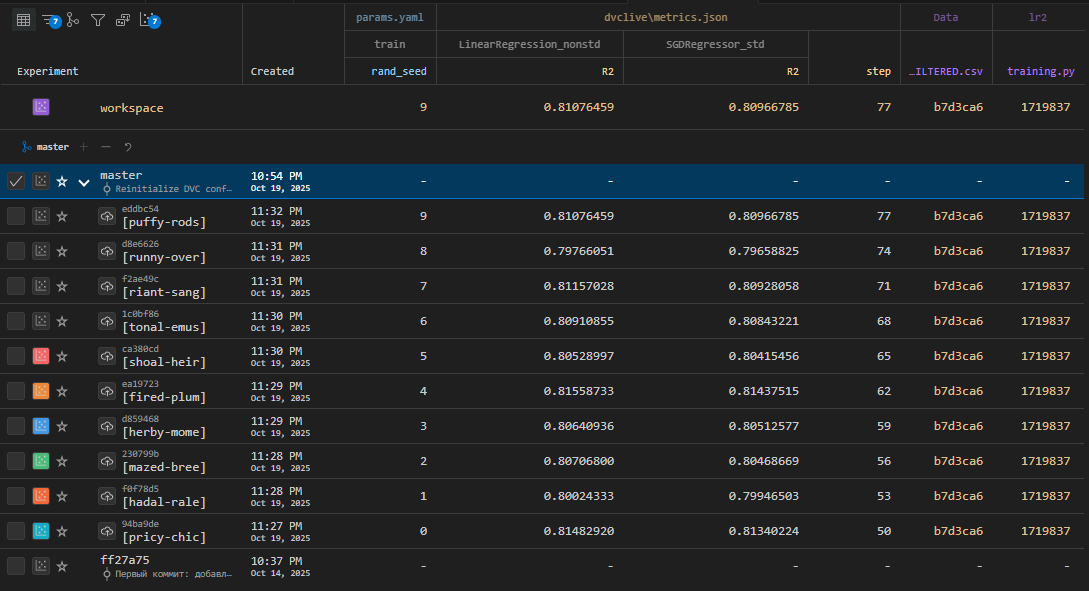

### Влияние стандартизации

При обучении модели SGDRegressor без предварительной стандартизации признаков алгоритм не сошёлся — обучение не завершилось корректно, и модель не выдала осмысленных результатов. Это связано с тем, что стохастический градиентный спуск чувствителен к масштабу признаков: при больших различиях в диапазонах значений отдельных переменных шаг градиентного обновления становится неравномерным, что приводит к колебаниям и невозможности достижения минимума функции ошибки.
После применения стандартизации данных (приведения всех признаков к одному масштабу со средним 0 и стандартным отклонением 1) алгоритм стабильно сходился, обеспечивая воспроизводимые результаты с высоким коэффициентом детерминации (R² ≈ 0.81).
Таким образом, стандартизация является необходимым этапом при использовании стохастического градиентного спуска, поскольку обеспечивает корректную работу метода и стабильность обучения.

В отличие от SGDRegressor, метод линейной регрессии на основе аналитического решения (метод наименьших квадратов) успешно сошёлся даже на не стандартизованных данных. Это объясняется тем, что классическая линейная регрессия не использует итерационный процесс оптимизации — параметры модели вычисляются напрямую через обращение матрицы признаков, поэтому масштаб отдельных переменных не влияет на сходимость алгоритма.

При сравнении метрик качества обе модели показали близкие результаты, однако линейная регрессия стабильно демонстрировала слегка лучшие значения R² и меньшие ошибки. Это можно объяснить тем, что аналитическое решение обеспечивает точное нахождение минимума функции ошибки, в то время как стохастический градиентный спуск (SGDRegressor) лишь приближает этот минимум в зависимости от параметров обучения (скорости обучения, количества итераций и случайного перемешивания).

Таким образом, можно сделать вывод, что линейная регрессия обеспечивает более устойчивые и точные результаты при небольших объёмах данных и низкой размерности признаков, тогда как SGDRegressor целесообразнее применять при работе с большими наборами данных, где аналитическое вычисление параметров становится вычислительно неэффективным.

### Влияние перемешивания

In [ ]:
# 1. Загружаем JSON
with open("exp.json", "r") as f:
    data = json.load(f)

# 2. Функция для извлечения метрик из одной записи
def extract_metrics(exp):
    rows = []
    rev = exp.get("rev", "unknown")
    metrics = exp.get("data", {}).get("metrics", {})
    dvclive_metrics = metrics.get("dvclive\\metrics.json", {}).get("data", {})
    for model_name, model_metrics in dvclive_metrics.items():
        if model_name == "step":
            continue
        row = {"experiment": rev, "model": model_name}
        row.update(model_metrics)
        rows.append(row)
    # Рекурсивно обрабатываем вложенные эксперименты
    for nested in exp.get("experiments") or []:
        for r in nested.get("revs", []):
            rows.extend(extract_metrics(r))
    return rows

# 3. Собираем все метрики в DataFrame
all_rows = []
for exp in data:
    all_rows.extend(extract_metrics(exp))

df_exp = pd.DataFrame(all_rows)
df_exp = df_exp[df_exp['experiment'] != 'workspace']
df_exp[0:6]

,experiment,model,MAE,MSE,RMSE,R2
3,eddbc54459ef9dbbd9104b47f1ce17820f405d83,SGDRegressor_nonstd,1.485433e+21,2.971359e+42,1.723763e+21,-1.230450e+28
4,eddbc54459ef9dbbd9104b47f1ce17820f405d83,LinearRegression_nonstd,4.211380e+06,4.569761e+13,6.760001e+06,8.107646e-01
5,eddbc54459ef9dbbd9104b47f1ce17820f405d83,SGDRegressor_std,2.597644e-01,1.705876e-01,4.130225e-01,8.096678e-01
6,d8e662682a7f5082dce2ca4681562932c46006dd,SGDRegressor_nonstd,3.573028e+22,1.716817e+45,4.143448e+22,-6.784953e+30
7,d8e662682a7f5082dce2ca4681562932c46006dd,LinearRegression_nonstd,4.393033e+06,5.119856e+13,7.155317e+06,7.976605e-01
8,d8e662682a7f5082dce2ca4681562932c46006dd,SGDRegressor_std,2.681757e-01,1.945538e-01,4.410826e-01,7.965883e-01


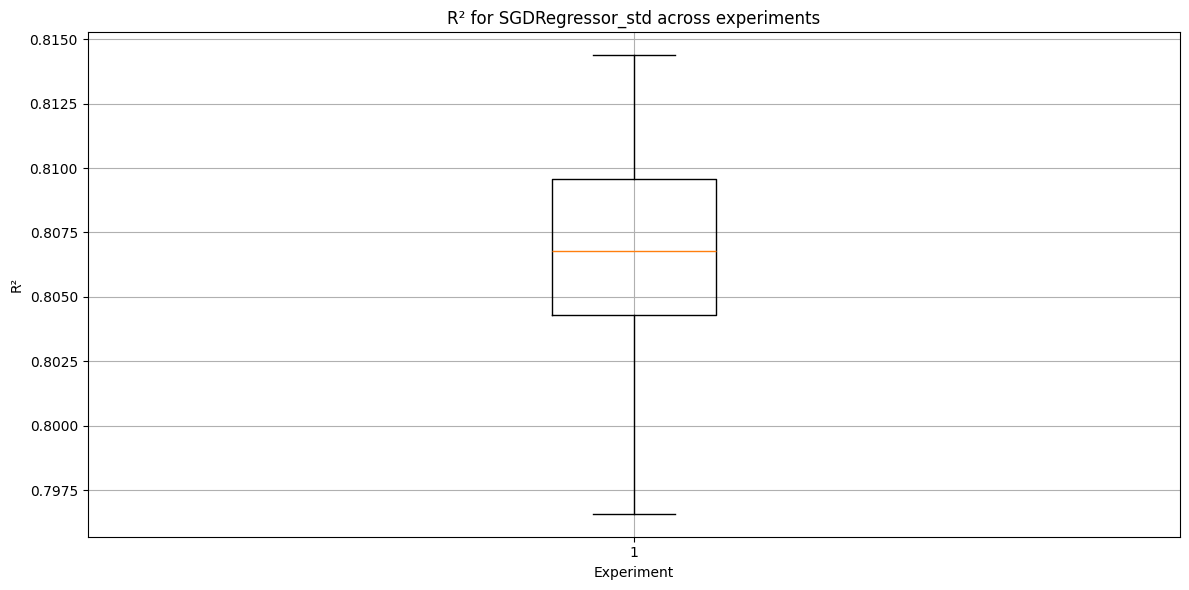

In [ ]:
# Фильтруем только стандартизованный регрессор
df_std = df_exp[df_exp['model'] == 'SGDRegressor_std']

# Строим диаграмму R2
plt.figure(figsize=(12,6))
plt.boxplot(df_std['R2'])
plt.xlabel("Experiment")
plt.ylabel("R²")
plt.title("R² for SGDRegressor_std across experiments")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_std.describe()

,MAE,MSE,RMSE,R2
count,10.000000,10.000000,10.000000,10.000000
mean,0.268002,0.183956,0.428740,0.806518
std,0.005827,0.010501,0.012373,0.005672
min,0.259764,0.164386,0.405445,0.796588
25%,0.265185,0.177431,0.421207,0.804288
50%,0.268552,0.187378,0.432870,0.806779
75%,0.270645,0.191783,0.437927,0.809571
max,0.278805,0.194788,0.441348,0.814375


### Анализ влияния перемешивания (shuffle) на SGDRegressor_std

На основе предоставленных статистических данных по 10 экспериментам можно сделать следующие выводы о влиянии перемешивания данных при обучении `SGDRegressor`.

---

#### 1. Стабильность результатов

Ключевой вывод из таблицы — **результаты модели очень стабильны**, несмотря на 10 разных запусков.

* **Низкое стандартное отклонение (std):** По всем метрикам наблюдается очень низкое стандартное отклонение (std) по отношению к среднему (mean).
    * **R2 (std):** $0.0057$ при среднем $0.8065$.
    * **MAE (std):** $0.0058$ при среднем $0.2680$.
* **Узкий диапазон (min/max):** Разброс между худшим (min) и лучшим (max) результатом также минимален. Например, R2 колеблется всего лишь от $0.796$ до $0.814$.

---

#### 2. Интерпретация влияния перемешивания

`SGDRegressor` (Стохастический Градиентный Спуск) — это итеративный алгоритм, который обновляет веса модели на основе небольших порций данных (батчей) или отдельных примеров.

* Зачем нужно перемешивание: Перемешивание (`shuffle=True`, что обычно используется по умолчанию) необходимо, чтобы на каждом шаге обучения (в каждой эпохе) модель видела данные в случайном порядке. Это предотвращает "застревание" модели в плохом решении (локальном минимуме), которое могло бы возникнуть, если бы данные подавались в одном и том же, возможно, отсортированном (смещенном) порядке.

* Перемешивание практически не влияет на качество модели: Все метрики колеблются в очень узких пределах. Это говорит о том, что данные достаточно однородны, и порядок их подачи при обучении не оказывает существенного влияния.

* Главный вывод: Данные показывают, что, хотя перемешивание и вносит элемент случайности (стохастичность) в процесс обучения, **этот фактор не приводит к нестабильности**. Модель стабильно сходится к очень похожему, качественному результату (средний $R^2 \approx 80.7\%$).

#### Итог

Перемешивание (Shuffling) является **критически важным** компонентом для `SGDRegressor`. Оно позволяет модели находить хорошее обобщающее решение и не зависеть от порядка данных.

...

# Кросс-валидация

Ввиду того, что при разделении на обучающую и проверочные части используется случайный выбор, оценки точности обученной модели будут напрямую зависеть каждого нового случайного распределения образцов. При этом, от случая к случаю, оценки точности будут изменяться.


Для получения более объективной оценки применяется прием Кросс-валидации (cross-validation) или скользящего контроля — процедура эмпирического оценивания обобщающей способности алгоритмов.
Обобщающая способность — это способность модели выдавать правильные результаты не только для примеров, участвовавших в процессе обучения, но и для любых новых, проверочных.

Обучающая (Train) часть выборки разделяется на K-частей, для каждой из которых:
 - происходит создание и обучение модели на данных, не принадлежащих текущей K-части
 - полученная промежуточная модель получает оценку точности по образцам K-части

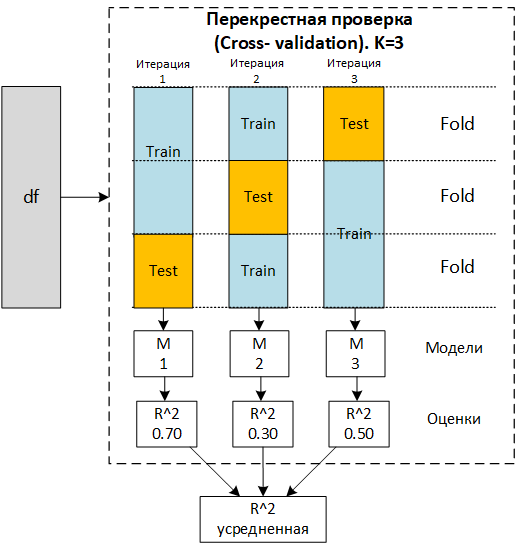



В библиотеке sklearn в пакете sklearn.model_selection присутствуют следующие функции

- cross_val_score (estimator, X, y, cv, scoring) - получение единственной метрики
- cross_validate  (estimator, X, y, cv, scoring) - получение нескольких метрик
- cross_val_predict(estimator, X, y, cv=3) - получение откликов, вычисленных моделью над набором входных значений

где, scoring - Метрики регрессии имеет режимы:
  - r2 - коэфф. детерминации (R2)
  - neg_mean_squared_error - ср. кв. ошибка (MSE)
  - neg_root_mean_squared_error - кв. корень из ср. кв. ошибки (RMSE)

In [ ]:
modelForCV =  linear_model.SGDRegressor(
    max_iter=10000,
    tol=1e-3,
    random_state=8,
)

In [ ]:
print("R2. НЕ Стандартизированные  проверочные данные")
scores_cross = cross_val_score(
                                    estimator = modelForCV, # Модель для обучения (вызова метода .fit())
                                    X=x_test_enc,   # Независимые переменные
                                    y=y_test,   # Целевая переменная
                                    cv=3,       # Кол-во K-частей (Fold)
                                    scoring='r2'# Режим расчитываемой метрики
                                )

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", scores_cross.mean())

R2. НЕ Стандартизированные  проверочные данные
Значения метрики по каждому блоку cv: [-5.95178343e+31 -1.29473625e+30 -3.13095664e+30]
Усредненное значение метрики: -2.131450906285922e+31


In [ ]:
print("R2. Стандартизированные проверочные данные")
scores_cross = cross_val_score(
                                    estimator = modelForCV, # Модель для обучения (вызова метода .fit())
                                    X=x_test_enc_std,   # Независимые переменные
                                    y=y_test_std.values.ravel(),   # Целевая переменная
                                    cv=3,       # Кол-во K-частей (Fold)
                                    scoring='r2'# Режим расчитываемой метрики
                                )

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", scores_cross.mean())

R2. Стандартизированные проверочные данные
Значения метрики по каждому блоку cv: [0.79653452 0.80885749 0.78568331]
Усредненное значение метрики: 0.797025105877792


In [ ]:
print("RMSE. НЕ Стандартизированные проверочные данные")
scores_cross = cross_val_score(
                                    estimator = modelForCV, # Модель для обучения (вызова метода .fit())
                                    X=x_test_enc,   # Независимые переменные
                                    y=y_test,   # Целевая переменная
                                    cv=3,       # Кол-во K-частей (Fold)
                                    scoring='neg_root_mean_squared_error' # Режим расчитываемой метрики
                                )

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", scores_cross.mean())

RMSE. НЕ Стандартизированные проверочные данные
Значения метрики по каждому блоку cv: [-1.21180141e+23 -1.83776808e+22 -2.80546397e+22]
Усредненное значение метрики: -5.5870820611277965e+22


In [ ]:
print("RMSE. Стандартизированные проверочные данные")
scores_cross = cross_val_score(
                                    estimator = modelForCV, # Модель для обучения (вызова метода .fit())
                                    X=x_test_enc_std,   # Независимые переменные
                                    y=y_test_std.values.ravel(),   # Целевая переменная
                                    cv=3,       # Кол-во K-частей (Fold)
                                    scoring='neg_root_mean_squared_error'# Режим расчитываемой метрики
                                )

print("Значения метрики по каждому блоку cv:", scores_cross)
print("Усредненное значение метрики:", scores_cross.mean())

RMSE. Стандартизированные проверочные данные
Значения метрики по каждому блоку cv: [-0.43560877 -0.43413224 -0.4512711 ]
Усредненное значение метрики: -0.4403373691311517


В scikit-learn метрики ошибок (MSE, RMSE, MAE и т.п.) в cross_val_score() всегда возвращаются с отрицательным знаком, если они относятся к ошибке, а не к точности.

Это сделано специально, чтобы все метрики могли использоваться в едином интерфейсе cross_val_score и при оптимизации (например, в GridSearchCV) —
так как cross_val_score всегда максимизирует метрику, а не минимизирует.

## Заключение о величине коридора изменений оценок моделей

### Сравнение результатов SGDRegressor на стандартизированных и нестандартизированных данных

| Метрика | Данные | Значения по блокам CV | Среднее значение | Интерпретация |
|----------|---------|-----------------------|------------------|----------------|
| **R²** | Не стандартизированные | [-5.95e+31, -1.29e+30, -3.13e+30] | **-2.13e+31** | Модель полностью не сошлась. Отрицательные значения R² такого масштаба означают, что предсказания модели значительно хуже среднего значения. Вероятная причина — масштаб признаков: градиентный спуск не смог подобрать веса. |
| **R²** | Стандартизированные | [0.7965, 0.8089, 0.7857] | **0.7970** | После стандартизации данные стали сравнимы по масштабу, и модель корректно сошлась. Значения R² ≈ 0.8 указывают на хорошее качество аппроксимации. |
| **RMSE** | Не стандартизированные | [-1.21e+23, -1.84e+22, -2.81e+22] | **-5.59e+22** | Ошибка гигантского масштаба подтверждает, что модель «разошлась» — значения весов выросли до огромных чисел. |
| **RMSE** | Стандартизированные | [-0.4356, -0.4341, -0.4513] | **-0.4403** | После смены масштаба признаки приобрели одинаковый вес в обучении, и ошибка стала разумной. RMSE ≈ 0.44 подтверждает устойчивую и стабильную сходимость. |

---

#### Выводы

1. **Стандартизация данных критически важна** для алгоритмов, основанных на стохастическом градиентном спуске (SGD).  
   Без приведения признаков к единому масштабу SGDRegressor не сходится, веса становятся огромными, а результат — хаотичным.

2. После стандартизации **модель стабильно обучается**, демонстрируя R² ≈ 0.8 и RMSE ≈ 0.44, что говорит о достаточно точных предсказаниях.

3. Таким образом, **стандартизация — необходимое условие корректной работы SGDRegressor**, особенно при работе с разнородными по масштабу признаками.


# Итоговые, сводные результаты и выводы.

Оцените в минутах время затраченное на выполнение основных этапов текущей работы, согласно методологии CRISP, затем заполните эту информацию в следующей ячейке для получения столбчатой диаграммы.

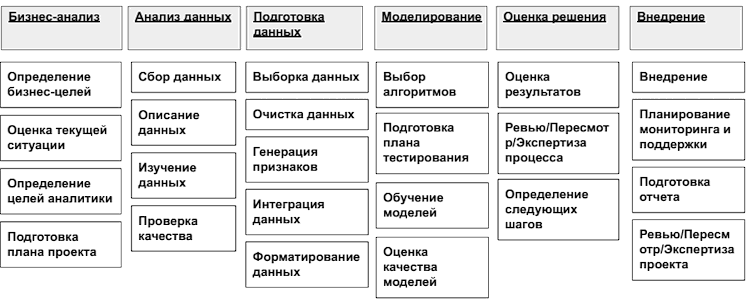

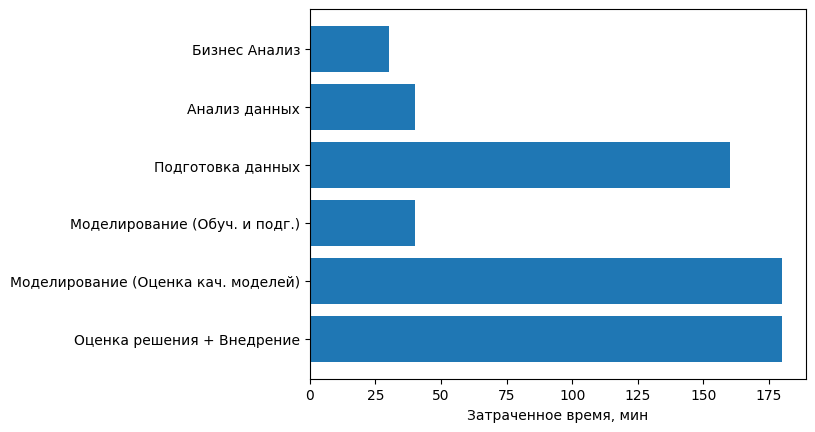

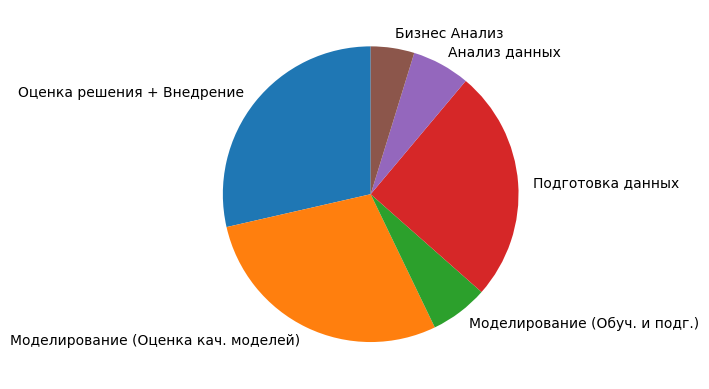

In [ ]:
# Создадим датафрейм для хранения значений
dfSpendTimeLab1 = pd.DataFrame.from_dict(
{
  "1": {"step": "Бизнес Анализ",                       "duration, min" : 30  },
  "2": {"step": "Анализ данных",                       "duration, min" : 40  },
  "3": {"step": "Подготовка данных",                   "duration, min" : 160 },
  "4": {"step": "Моделирование (Обуч. и подг.)",       "duration, min" : 40  },
  "5": {"step": "Моделирование (Оценка кач. моделей)", "duration, min" : 180 },
  "6": {"step": "Оценка решения + Внедрение",          "duration, min" : 180 },
}, orient="index"
).sort_index(ascending=False)

# Построить столбчатую диаграмму
fig = plt.figure()
plt.barh(y = dfSpendTimeLab1["step"], width= dfSpendTimeLab1["duration, min"], )
plt.xlabel("Затраченное время, мин")

# Построить круговую диаграмму
fig = plt.figure()
plt.pie(x= dfSpendTimeLab1["duration, min"], labels=dfSpendTimeLab1["step"],  startangle = 90 )

plt.show()

...

...

...